In [1]:
import pandas as pd
import numpy as np
import shutil
import multiprocessing
from datetime import datetime

import tensorflow as tf
from tensorflow.python.feature_column import feature_column
from tensorflow.contrib.learn import learn_runner
from tensorflow.contrib.learn import make_export_strategy
from tensorflow import data

print(tf.__version__)

/Users/khalidsalama/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


1.4.0


## TF Custom Estimator to Build a NN Autoencoder for Feature Extraction

In [2]:
MODEL_NAME = 'auto-encoder-01'

TRAIN_DATA_FILES_PATTERN = 'data/data-*.csv'

RESUME_TRAINING = False

MULTI_THREADING = True

## 1. Define Dataset Metadata

In [3]:
FEATURE_COUNT = 64

HEADER = ['key']
HEADER_DEFAULTS = [[0]]
UNUSED_FEATURE_NAMES = ['key']
CLASS_FEATURE_NAME = 'CLASS'
FEATURE_NAMES = []  

for i in range(FEATURE_COUNT):
    HEADER += ['x_{}'.format(str(i+1))]
    FEATURE_NAMES += ['x_{}'.format(str(i+1))]
    HEADER_DEFAULTS += [[0.0]]

HEADER += [CLASS_FEATURE_NAME]
HEADER_DEFAULTS += [['NA']]

print("Header: {}".format(HEADER))
print("Features: {}".format(FEATURE_NAMES))
print("Class Feature: {}".format(CLASS_FEATURE_NAME))
print("Unused Features: {}".format(UNUSED_FEATURE_NAMES))

Header: ['key', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18', 'x_19', 'x_20', 'x_21', 'x_22', 'x_23', 'x_24', 'x_25', 'x_26', 'x_27', 'x_28', 'x_29', 'x_30', 'x_31', 'x_32', 'x_33', 'x_34', 'x_35', 'x_36', 'x_37', 'x_38', 'x_39', 'x_40', 'x_41', 'x_42', 'x_43', 'x_44', 'x_45', 'x_46', 'x_47', 'x_48', 'x_49', 'x_50', 'x_51', 'x_52', 'x_53', 'x_54', 'x_55', 'x_56', 'x_57', 'x_58', 'x_59', 'x_60', 'x_61', 'x_62', 'x_63', 'x_64', 'CLASS']
Features: ['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18', 'x_19', 'x_20', 'x_21', 'x_22', 'x_23', 'x_24', 'x_25', 'x_26', 'x_27', 'x_28', 'x_29', 'x_30', 'x_31', 'x_32', 'x_33', 'x_34', 'x_35', 'x_36', 'x_37', 'x_38', 'x_39', 'x_40', 'x_41', 'x_42', 'x_43', 'x_44', 'x_45', 'x_46', 'x_47', 'x_48', 'x_49', 'x_50', 'x_51', 'x_52', 'x_53', 'x_54', 'x_55', 'x_56', 'x_57', 'x_58', 'x_59'

## 2. Define CSV Data Input Function

In [4]:
def parse_csv_row(csv_row):
    
    columns = tf.decode_csv(csv_row, record_defaults=HEADER_DEFAULTS)
    features = dict(zip(HEADER, columns))
    
    for column in UNUSED_FEATURE_NAMES:
        features.pop(column)

    target = features.pop(CLASS_FEATURE_NAME)

    return features, target

In [5]:
def csv_input_fn(files_name_pattern, mode=tf.estimator.ModeKeys.EVAL, 
                 skip_header_lines=0, 
                 num_epochs=None, 
                 batch_size=200):
    
    shuffle = True if mode == tf.estimator.ModeKeys.TRAIN else False
    
    print("")
    print("* data input_fn:")
    print("================")
    print("Input file(s): {}".format(files_name_pattern))
    print("Batch size: {}".format(batch_size))
    print("Epoch Count: {}".format(num_epochs))
    print("Mode: {}".format(mode))
    print("Shuffle: {}".format(shuffle))
    print("================")
    print("")
    
    file_names = tf.matching_files(files_name_pattern)

    dataset = data.TextLineDataset(filenames=file_names)
    dataset = dataset.skip(skip_header_lines)
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=2 * batch_size + 1)
        
    num_threads = multiprocessing.cpu_count() if MULTI_THREADING else 1
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda csv_row: parse_csv_row(csv_row), num_parallel_calls=num_threads)
    
    dataset = dataset.repeat(num_epochs)
    iterator = dataset.make_one_shot_iterator()
    
    features, target = iterator.get_next()

    return features, target

In [6]:
features, target = csv_input_fn(files_name_pattern="")
print("Feature read from CSV: {}".format(list(features.keys())))
print("Target read from CSV: {}".format(target))


* data input_fn:
Input file(s): 
Batch size: 200
Epoch Count: None
Mode: eval
Shuffle: False

Feature read from CSV: ['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18', 'x_19', 'x_20', 'x_21', 'x_22', 'x_23', 'x_24', 'x_25', 'x_26', 'x_27', 'x_28', 'x_29', 'x_30', 'x_31', 'x_32', 'x_33', 'x_34', 'x_35', 'x_36', 'x_37', 'x_38', 'x_39', 'x_40', 'x_41', 'x_42', 'x_43', 'x_44', 'x_45', 'x_46', 'x_47', 'x_48', 'x_49', 'x_50', 'x_51', 'x_52', 'x_53', 'x_54', 'x_55', 'x_56', 'x_57', 'x_58', 'x_59', 'x_60', 'x_61', 'x_62', 'x_63', 'x_64']
Target read from CSV: Tensor("IteratorGetNext:64", shape=(?,), dtype=string)


## 3. Define Feature Columns

### a. Load normalizarion params

In [7]:
df_params = pd.read_csv("data/params.csv", header=0, index_col=0)
len(df_params)
df_params['feature_name'] = FEATURE_NAMES
df_params.head()

,max,mean,min,stdv,feature_name
0,8.613757,-0.459068,-9.810630,2.931419,x_1
1,27.206817,0.452976,-40.614726,8.505586,x_2
2,3.127243,0.019996,-3.386526,1.014950,x_3
3,3.505720,-0.044230,-3.662128,0.992678,x_4
4,10.622091,0.912562,-10.656254,3.155885,x_5


###  b. Create normalized feature columns

In [8]:
def standard_scaler(x, mean, stdv):
    return (x-mean)/stdv

def maxmin_scaler(x, max_value, min_value):
    return (x-min_value)/(max_value-min_value)

def get_feature_columns():
    
    feature_columns = {}
    

#     feature_columns = {feature_name: tf.feature_column.numeric_column(feature_name)
#                        for feature_name in FEATURE_NAMES}

    for feature_name in FEATURE_NAMES:

        feature_max = df_params[df_params.feature_name == feature_name]['max'].values[0]
        feature_min = df_params[df_params.feature_name == feature_name]['min'].values[0]
        normalizer_fn = lambda x: maxmin_scaler(x, feature_max, feature_min)
        
        feature_columns[feature_name] = tf.feature_column.numeric_column(feature_name, 
                                                                         normalizer_fn=normalizer_fn
                                                                        )
 

    return feature_columns

print(get_feature_columns())

{'x_1': _NumericColumn(key='x_1', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function get_feature_columns.<locals>.<lambda> at 0x118644048>), 'x_2': _NumericColumn(key='x_2', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function get_feature_columns.<locals>.<lambda> at 0x11862ae18>), 'x_3': _NumericColumn(key='x_3', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function get_feature_columns.<locals>.<lambda> at 0x1160fe488>), 'x_4': _NumericColumn(key='x_4', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function get_feature_columns.<locals>.<lambda> at 0x11862a598>), 'x_5': _NumericColumn(key='x_5', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function get_feature_columns.<locals>.<lambda> at 0x11862ad90>), 'x_6': _NumericColumn(key='x_6', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function get_feature_columns.<locals>.<lambda> at 0x118653158>), 'x_7': _NumericColumn

## 4. Define Autoencoder Model Function

In [9]:
def autoencoder_model_fn(features, labels, mode, params):
    
    feature_columns = list(get_feature_columns().values())
    
    input_layer_size = len(feature_columns)
    
    encoder_hidden_units = params.encoder_hidden_units
    
    # decoder units are the reverse of the encoder units, without the middle layer (redundant)
    decoder_hidden_units = encoder_hidden_units.copy()  
    decoder_hidden_units.reverse()
    decoder_hidden_units.pop(0)
    
    output_layer_size = len(FEATURE_NAMES)
    
    he_initialiser = tf.contrib.layers.variance_scaling_initializer()
    l2_regulariser = tf.contrib.layers.l2_regularizer(scale=params.l2_reg)
    
  
    print("[{}]->{}-{}->[{}]".format(len(feature_columns)
                                     ,encoder_hidden_units
                                     ,decoder_hidden_units,
                                     output_layer_size))

    is_training = (mode == tf.estimator.ModeKeys.TRAIN)
    
    # input layer
    input_layer = tf.feature_column.input_layer(features=features, 
                                                feature_columns=feature_columns)
    
    # Adding Gaussian Noise to input layer
    noisy_input_layer = input_layer + (params.noise_level * tf.random_normal(tf.shape(input_layer)))
    
    # Dropout layer
    dropout_layer = tf.layers.dropout(inputs=noisy_input_layer, 
                                     rate=params.dropout_rate, 
                                     training=is_training)

#     # Dropout layer without Gaussian Nosing
#     dropout_layer = tf.layers.dropout(inputs=input_layer, 
#                                       rate=params.dropout_rate, 
#                                       training=is_training)

    # Encoder layers stack
    encoding_hidden_layers = tf.contrib.layers.stack(inputs= dropout_layer,
                                                     layer= tf.contrib.layers.fully_connected,
                                                     stack_args=encoder_hidden_units,
                                                     #weights_initializer = he_init,
                                                     weights_regularizer =l2_regulariser,
                                                     activation_fn = tf.nn.relu
                                                    )
    # Decoder layers stack
    decoding_hidden_layers = tf.contrib.layers.stack(inputs=encoding_hidden_layers,
                                                     layer=tf.contrib.layers.fully_connected,                
                                                     stack_args=decoder_hidden_units,
                                                     #weights_initializer = he_init,
                                                     weights_regularizer =l2_regulariser,
                                                     activation_fn = tf.nn.relu
                                                    )
    # Output (reconstructed) layer
    output_layer = tf.layers.dense(inputs=decoding_hidden_layers, 
                             units=output_layer_size, activation=None)
    
    # Encoding output (i.e., extracted features) reshaped
    encoding_output = tf.squeeze(encoding_hidden_layers)
    
    # Reconstruction output reshaped (for serving function)
    reconstruction_output =  tf.squeeze(tf.nn.sigmoid(output_layer))
    
    # Provide an estimator spec for `ModeKeys.PREDICT`.
    if mode == tf.estimator.ModeKeys.PREDICT:
        
        # Convert predicted_indices back into strings
        predictions = {
            'encoding': encoding_output,
            'reconstruction': reconstruction_output
        }
        export_outputs = {
            'predict': tf.estimator.export.PredictOutput(predictions)
        }
        
        # Provide an estimator spec for `ModeKeys.PREDICT` modes.
        return tf.estimator.EstimatorSpec(mode,
                                          predictions=predictions,
                                          export_outputs=export_outputs)
    
    # Define loss based on reconstruction and regularization
    
#     reconstruction_loss = tf.losses.mean_squared_error(tf.squeeze(input_layer), reconstruction_output) 
#     loss = reconstruction_loss + tf.losses.get_regularization_loss()
    
    reconstruction_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.squeeze(input_layer), logits=tf.squeeze(output_layer))
    loss = reconstruction_loss + tf.losses.get_regularization_loss()
                         
    # Create Optimiser
    optimizer = tf.train.AdamOptimizer(params.learning_rate)

    # Create training operation
    train_op = optimizer.minimize(
        loss=loss, global_step=tf.train.get_global_step())

    # Calculate root mean squared error as additional eval metric
    eval_metric_ops = {
        "rmse": tf.metrics.root_mean_squared_error(
            tf.squeeze(input_layer), reconstruction_output)
    }
                                                     
    # Provide an estimator spec for `ModeKeys.EVAL` and `ModeKeys.TRAIN` modes.
    estimator_spec = tf.estimator.EstimatorSpec(mode=mode,
                                                loss=loss,
                                                train_op=train_op,
                                                eval_metric_ops=eval_metric_ops)
    return estimator_spec


def create_estimator(run_config, hparams):
    estimator = tf.estimator.Estimator(model_fn=autoencoder_model_fn, 
                                  params=hparams, 
                                  config=run_config)
    
    print("")
    print("Estimator Type: {}".format(type(estimator)))
    print("")

    return estimator

## 5. Run Experiment using Estimator Train_And_Evaluate

### a. Set the parameters

In [10]:
TRAIN_SIZE = 2000
NUM_EPOCHS = 1000
BATCH_SIZE = 100
NUM_EVAL = 10

TOTAL_STEPS = (TRAIN_SIZE/BATCH_SIZE)*NUM_EPOCHS
CHECKPOINT_STEPS = int((TRAIN_SIZE/BATCH_SIZE) * (NUM_EPOCHS/NUM_EVAL))

hparams  = tf.contrib.training.HParams(
    num_epochs = NUM_EPOCHS,
    batch_size = BATCH_SIZE,
    encoder_hidden_units=[30,3],
    learning_rate = 0.01,
    l2_reg = 0.0001,
    noise_level = 0.0,
    max_steps = TOTAL_STEPS,
    dropout_rate = 0.05
)

model_dir = 'trained_models/{}'.format(MODEL_NAME)

run_config = tf.contrib.learn.RunConfig(
    save_checkpoints_steps=CHECKPOINT_STEPS,
    tf_random_seed=19830610,
    model_dir=model_dir
)

print(hparams)
print("Model Directory:", run_config.model_dir)
print("")
print("Dataset Size:", TRAIN_SIZE)
print("Batch Size:", BATCH_SIZE)
print("Steps per Epoch:",TRAIN_SIZE/BATCH_SIZE)
print("Total Steps:", TOTAL_STEPS)
print("Required Evaluation Steps:", NUM_EVAL) 
print("That is 1 evaluation step after each",NUM_EPOCHS/NUM_EVAL," epochs")
print("Save Checkpoint After",CHECKPOINT_STEPS,"steps")

[('batch_size', 100), ('dropout_rate', 0.05), ('encoder_hidden_units', [30, 3]), ('l2_reg', 0.0001), ('learning_rate', 0.01), ('max_steps', 20000.0), ('noise_level', 0.0), ('num_epochs', 1000)]
Model Directory: trained_models/auto-encoder-01

Dataset Size: 2000
Batch Size: 100
Steps per Epoch: 20.0
Total Steps: 20000.0
Required Evaluation Steps: 10
That is 1 evaluation step after each 100.0  epochs
Save Checkpoint After 2000 steps


### b. Define TrainSpec and EvaluSpec

In [11]:
train_spec = tf.estimator.TrainSpec(
    input_fn = lambda: csv_input_fn(
        TRAIN_DATA_FILES_PATTERN,
        mode = tf.contrib.learn.ModeKeys.TRAIN,
        num_epochs=hparams.num_epochs,
        batch_size=hparams.batch_size
    ),
    max_steps=hparams.max_steps,
    hooks=None
)

eval_spec = tf.estimator.EvalSpec(
    input_fn = lambda: csv_input_fn(
        TRAIN_DATA_FILES_PATTERN,
        mode=tf.contrib.learn.ModeKeys.EVAL,
        num_epochs=1,
        batch_size=hparams.batch_size
    ),
#     exporters=[tf.estimator.LatestExporter(
#         name="encode",  # the name of the folder in which the model will be exported to under export
#         serving_input_receiver_fn=csv_serving_input_fn,
#         exports_to_keep=1,
#         as_text=True)],
    steps=None,
    hooks=None
)

### d. Run Experiment via train_and_evaluate

In [12]:
if not RESUME_TRAINING:
    print("Removing previous artifacts...")
    shutil.rmtree(model_dir, ignore_errors=True)
else:
    print("Resuming training...") 

    
tf.logging.set_verbosity(tf.logging.INFO)

time_start = datetime.utcnow() 
print("Experiment started at {}".format(time_start.strftime("%H:%M:%S")))
print(".......................................") 

estimator = create_estimator(run_config, hparams)

tf.estimator.train_and_evaluate(
    estimator=estimator,
    train_spec=train_spec, 
    eval_spec=eval_spec
)

time_end = datetime.utcnow() 
print(".......................................")
print("Experiment finished at {}".format(time_end.strftime("%H:%M:%S")))
print("")
time_elapsed = time_end - time_start
print("Experiment elapsed time: {} seconds".format(time_elapsed.total_seconds()))
    

Removing previous artifacts...
Experiment started at 21:41:40
.......................................
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x118884668>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': 19830610, '_save_summary_steps': 100, '_save_checkpoints_secs': None, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': 2000, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'trained_models/auto-encoder-01'}

Estimator Type: <class 'tensorflow.python.estimator.estimator.Estimator'>

INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 600 secs (eval

INFO:tensorflow:global_step/sec: 141.121
INFO:tensorflow:loss = -1.68339e+08, step = 6601 (0.709 sec)
INFO:tensorflow:global_step/sec: 141.021
INFO:tensorflow:loss = -1.3578e+08, step = 6701 (0.709 sec)
INFO:tensorflow:global_step/sec: 142.452
INFO:tensorflow:loss = -2.25908e+08, step = 6801 (0.702 sec)
INFO:tensorflow:global_step/sec: 143.303
INFO:tensorflow:loss = -3.92238e+08, step = 6901 (0.698 sec)
INFO:tensorflow:global_step/sec: 143.688
INFO:tensorflow:loss = -8.33598e+07, step = 7001 (0.697 sec)
INFO:tensorflow:global_step/sec: 144.553
INFO:tensorflow:loss = -1.61669e+08, step = 7101 (0.691 sec)
INFO:tensorflow:global_step/sec: 140.124
INFO:tensorflow:loss = -1.98041e+08, step = 7201 (0.713 sec)
INFO:tensorflow:global_step/sec: 142.028
INFO:tensorflow:loss = -4.24831e+08, step = 7301 (0.704 sec)
INFO:tensorflow:global_step/sec: 140.358
INFO:tensorflow:loss = -4.38497e+08, step = 7401 (0.712 sec)
INFO:tensorflow:global_step/sec: 141.39
INFO:tensorflow:loss = -1.45828e+08, step =

INFO:tensorflow:global_step/sec: 139.074
INFO:tensorflow:loss = -2.29439e+09, step = 14301 (0.719 sec)
INFO:tensorflow:global_step/sec: 143.811
INFO:tensorflow:loss = -1.3227e+09, step = 14401 (0.696 sec)
INFO:tensorflow:global_step/sec: 137.196
INFO:tensorflow:loss = -3.67736e+09, step = 14501 (0.729 sec)
INFO:tensorflow:global_step/sec: 142.174
INFO:tensorflow:loss = -2.74288e+09, step = 14601 (0.703 sec)
INFO:tensorflow:global_step/sec: 140.236
INFO:tensorflow:loss = -3.35358e+09, step = 14701 (0.713 sec)
INFO:tensorflow:global_step/sec: 143.86
INFO:tensorflow:loss = -2.70737e+09, step = 14801 (0.695 sec)
INFO:tensorflow:global_step/sec: 142.46
INFO:tensorflow:loss = -1.38112e+09, step = 14901 (0.702 sec)
INFO:tensorflow:global_step/sec: 142.884
INFO:tensorflow:loss = -1.17051e+09, step = 15001 (0.704 sec)
INFO:tensorflow:global_step/sec: 140.569
INFO:tensorflow:loss = -1.82866e+09, step = 15101 (0.707 sec)
INFO:tensorflow:global_step/sec: 143.509
INFO:tensorflow:loss = -2.87066e+09

## 6. Use the trained model to encode data (prediction)

In [13]:
import itertools

DATA_SIZE = 2000

input_fn = lambda: csv_input_fn(
    TRAIN_DATA_FILES_PATTERN,
    mode=tf.contrib.learn.ModeKeys.INFER,
    num_epochs=1,
    batch_size=500
)

estimator = create_estimator(run_config, hparams)

predictions = estimator.predict(input_fn=input_fn)
predictions = itertools.islice(predictions, DATA_SIZE)
predictions = list(map(lambda item: list(item["encoding"]), predictions))

print(predictions[:5])

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x118884668>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': 19830610, '_save_summary_steps': 100, '_save_checkpoints_secs': None, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': 2000, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'trained_models/auto-encoder-01'}

Estimator Type: <class 'tensorflow.python.estimator.estimator.Estimator'>


* data input_fn:
Input file(s): data/data-*.csv
Batch size: 500
Epoch Count: 1
Mode: infer
Shuffle: False

[64]->[30, 3]-[30]->[64]
INFO:tensorflow:Restoring parameters from trained_models/auto-encoder-01/model.ckpt-20000
[[1218043.8, 2438282.0, 1206508.6], [5877218.5

## Visualise Encoded Data

In [14]:
y = pd.read_csv("data/data-01.csv", header=None, index_col=0)[65]

data_reduced = pd.DataFrame(predictions, columns=['c1','c2','c3'])
data_reduced['class'] = y
data_reduced.head()

,c1,c2,c3,class
0,1.218044e+06,2438282.00,1.206509e+06,2
1,5.877218e+06,0.00,5.859628e+06,0
2,4.590472e+05,2725077.75,4.490512e+05,0
3,0.000000e+00,4565467.50,0.000000e+00,2
4,0.000000e+00,4157996.50,0.000000e+00,2


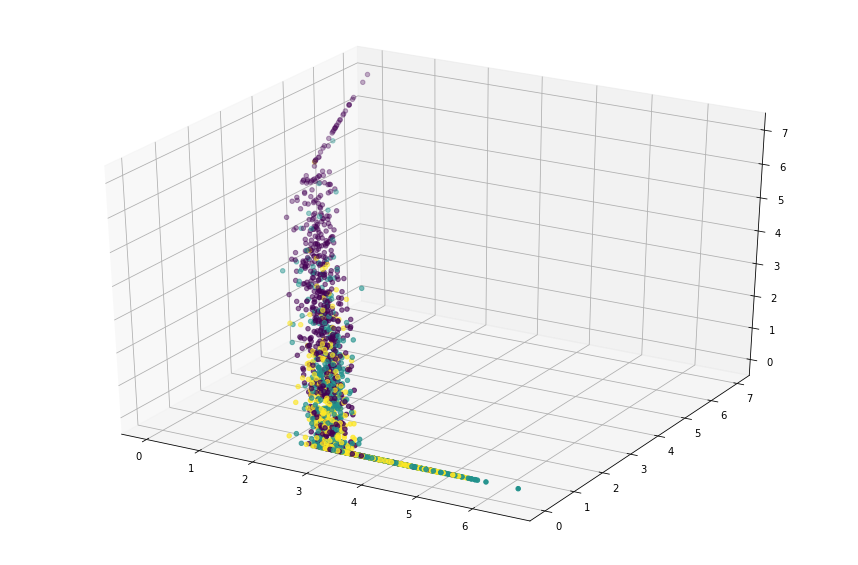

In [28]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=data_reduced.c2/1000000, ys=data_reduced.c3/1000000, zs=data_reduced.c1/1000000, c=data_reduced['class'], marker='o')
plt.show()

## Notes:

1. You can effectively implement a (linear) PCA by having only one hidden layer with no activation function

2. To improve the efficiency of training the model, the weights of the encoder and decoder layers can be tied (i.e., have the same values)